# <center> Six degrees of movies </center>

Plan
1. Formalize the desired outcome
2. Explore available data resources
3. Data scraping functions
    - Asyncronious requests with asyncio (new package to learn)
    - Postgres database storage functionality
    - Create a bulletproof parser that would be capble to complete the job on its own
        * Explore possibilities for logging (new package to learn)
        * Creation of necessary backups
4. Algorithm to look for the connecting links
5. Graphics creation with wordclouds
    - Frustration with data encoding
6. 

This project is aimed to create a simple backend infrastructure for a "guess" game that I have come up with. 

Given 2 distinct actors/actresses we can connect them through some mutual connections. These connections are established through the movies the actor/actress has starred in and the respective cast for that particular movie. Those are level-1 connections. Similarly, iterating through level-1 connections' movies, we can establish level-2 connections and so on. Hence, we get a connected graph made of people as vertices and movies as edges. The same approach can be applied to movies that are deemed to be connected through actors/actresses. 

The "guess" game starts after the connecting "pieces" are found. The intermediate vertices are not going to be explicitly stated, but have to be guessed from a word cloud that is comprised of the roles the person has played. Movies, on the other hand, would have their description embedded into a word cloud.

## 1. Solution architecture

To tackle this task we need the data that would enable us to connect people through movies and vice versa. I will utilize information from IMDB website. So easy, IMDB got all the information stored in ready-made tables for us to download and put into use... No so fast. Let's take a look at some tables.

From this [link](https://www.imdb.com/interfaces/) here we can get 2 interesting datasets:
<table>
    <tr>
       <td> <center> Actors/Actresses data </center> </td> 
       <td> <center> Movie title data </center> </td>
    </tr>
    <tr>
       <td><img src="images/Names_tbl_IMDB.PNG" alt="Names" style="width: 500px; height: 150px" /> </td>
       <td> <img src="images/Movies_tbl_IMDB.PNG" alt="Movies" style="width: 500px; height: 150px" /> </td>
</tr></table>


I have downloaded the 2 datasets and unzipped them. Upon further inspection, though, the information presented does not seem complete:

   ###           Names dataset 

In [1]:
import pandas as pd

In [3]:
# Nan values are specified as \N (default for PostgreSQL)
df_names_dset = pd.read_csv(r"names.tsv", sep='\t', na_values='\\N')

In [4]:
df_names_dset.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0117057,tt0071877,tt0037382,tt0038355"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0057345,tt0054452,tt0056404,tt0049189"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0072562,tt0080455,tt0078723,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [5]:
df_names_dset.shape

(11365793, 6)

In [6]:
df_names_dset.loc[:, 'knownForTitles'].map(lambda x: str(x).split(',')).map(lambda y: len(y)).max()

6

First I create lists from strings with title ids and then find the length of each list and locate the max. It appears that `knownForTitles` column has at most 6 movies per name. 

In [7]:
df_names_dset[df_names_dset['primaryName'] == 'Brad Pitt']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
92,nm0000093,Brad Pitt,1963.0,NaN,"actor,producer,soundtrack","tt1210166,tt0114746,tt0356910,tt2935510"


Brad Pitt has only 4. Clearly top actors have starred in more pictures than that.

### Movies dataset

In [8]:
df_movies_dset = pd.read_csv('data.tsv', sep='\t', na_values='\\N')

In [9]:
df_movies_dset.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,NaN,"[""Self""]"
1,tt0000001,2,nm0005690,director,NaN,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography,NaN
3,tt0000002,1,nm0721526,director,NaN,NaN
4,tt0000002,2,nm1335271,composer,NaN,NaN


In [10]:
df_movies_dset.category.value_counts()

actor                  10715354
self                    8282716
actress                 8136955
writer                  6354300
director                5510362
producer                3019841
composer                1675693
cinematographer         1672899
editor                  1584835
production_designer      333427
archive_footage          297810
archive_sound              2819
Name: category, dtype: int64

I am only interested in actors and actresses, although `self` also seems to include the acting personnel. So, let's find how many actors/actresses per movie we can find at most in this dataset:

In [11]:
df_movies_dset[df_movies_dset['category'].isin(['actor', 'actress', 'self'])].groupby('tconst')['ordering'].count().max()

10

10 characters at most. Doesn't seem to be sufficient. The data will have to be scraped from the website. There is a public API available, although the free version of 100-1000 requests per day is not going to suffice for this project with ~8 million movies and even more cast. We will make sure not to interfere with servers too much in this process.

The data we want is presented in the static manner, so I BeautifulSoup from bs4 library would be able to handle the job pretty well.

## Imports

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import asyncio
import aiohttp
import nest_asyncio
import psycopg2
import psycopg2.extras
from config import config
import tqdm
import datetime
import pickle
from collections import deque
import networkx as nx
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
headers = {'Accept-language': 'en', 'X-FORWARDED-FOR': '134.201.250.155'}
%matplotlib inline

In [3]:
!which python

/c/Users/glady/.virtualenvs/My_Project-26ySI7fE/Scripts/python


In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\glady\.virtualenvs\My_Project-26ySI7fE\Scripts\python.exe
3.7.0 (v3.7.0:1bf9cc5093, Jun 27 2018, 04:59:51) [MSC v.1914 64 bit (AMD64)]
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)


## Main Functions

In [4]:
def sql_create_tables():
    conn = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        cur = conn.cursor()
        
        cur.execute('''CREATE TABLE IF NOT EXISTS actors (act_id VARCHAR(20) PRIMARY KEY, 
                                            name VARCHAR(80));''')
        
        cur.execute('''CREATE TABLE IF NOT EXISTS movies  (mov_id VARCHAR(20) PRIMARY KEY, 
                                            title VARCHAR(80),
                                            description VARCHAR(2000));''')

        cur.execute("""CREATE TABLE IF NOT EXISTS relations (mov_id VARCHAR(20), 
                                            act_id VARCHAR(20),
                                            roles VARCHAR(1000));""")
        
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

    finally:
        if conn is not None:
            conn.commit()
            conn.close()
    

In [5]:
# modify to keep connection open
def dump_movies(mov_list, connection=None):
    if not connection:
        params = config()
        connection = psycopg2.connect(**params)
    with connection.cursor() as cursor:
        psycopg2.extras.execute_batch(cursor, """
        INSERT INTO movies VALUES (%s, %s, %s);""", mov_list)
        
        connection.commit()
        
    global movies_to_upload
    movies_to_upload = set()
    
    

In [6]:
# modify to keep connection open
def dump_relations(relations_list, connection=None):
    if not connection:
        params = config()
        connection = psycopg2.connect(**params)
    with connection.cursor() as cursor:
        psycopg2.extras.execute_batch(cursor, """
        INSERT INTO relations VALUES (%s, %s, %s);""", relations_list)
        
        connection.commit()
        
    global relations_to_upload
    relations_to_upload = set()

In [7]:
# modify to keep connection open
def dump_actors(actors_list, connection=None):
    if not connection:
        params = config()
        connection = psycopg2.connect(**params)
    with connection.cursor() as cursor:
        psycopg2.extras.execute_batch(cursor, """
        INSERT INTO actors VALUES (%s, %s);""", actors_list)
        connection.commit()
    global actors_to_upload
    actors_to_upload = set()

In [8]:
def truncate_tables(connection=None):
    if not connection:
        params = config()
        connection = psycopg2.connect(**params)
    with connection.cursor() as cursor:
        cursor.execute('''TRUNCATE TABLE movies;''')
        cursor.execute('''TRUNCATE TABLE actors;''')
        cursor.execute('''TRUNCATE TABLE relations;''')
        
        connection.commit()
        

In [9]:
def get_actors_by_movie_soup(cast_page_soup, url, index):
    try:
        actor_list = []
        mov_up = set()
        global Errors_list
        try:
            mv_id = cast_page_soup.find('h3').find('a')['href'].split('/')[-2]
        except (AttributeError, TypeError, KeyboardInterrupt):
            Errors_list['Movies'].append(cast_page_soup)
            if cast_page_soup.find('meta', attrs={'name': True}):
                if cast_page_soup.find('meta')['name'] == 'MSSmartTagsPreventParsing':
                    print('oops')
                    raise ParsingError(f'sleep_{index}')
            else:
                raise KeyboardInterrupt(f'_{index}')


        try:
            act_res_set = cast_page_soup.find('div', attrs={'id': 'fullcredits_content'}) \
                                        .find('table', attrs={'class': 'cast_list'}) \
                                        .find_all('tr', attrs={'class': ['even', 'odd']})

    #         movie_load1 = movie_soup.find('h1').text
    #         movie_load2 = movie_soup.find('div', attrs={'data-testid': 'storyline-plot-summary'}) \
    #                                 .find('div', attrs={'class': None}).text.strip()




        except AttributeError as e:
            Errors_list['Movies'].append(mv_id)
            print(e)
            print('ERRORMOV')
            act_res_set = 0


        for actor in range(len(act_res_set)):
            try:
                actor_details = act_res_set[actor].find('td', attrs={'class': 'primary_photo'}).findNext('td')
                act_link = actor_details.find('a')
                actor_list.append('https://imdb.com' + act_link['href'])

            except (AttributeError, TypeError) as e:
                print(e)
                print('attr, type error for act', url)
                Errors_list['Actors'].append(actor)
                print('ERRORACT')


#         if len(movies_to_upload) > 1000:
#             dump_movies(movies_to_upload)
#             print('movies uploaded!!!')
    except KeyboardInterrupt:
        raise KeyboardInterrupt(f'{index}')
        
    return actor_list, mv_id

In [10]:
#'filming', 'pre-production', 'post-production', 'completed'

In [11]:
class ParsingError(Exception):
    pass

In [12]:
def get_movies_by_actor_soup(actor_page_soup, index):
    movies_list = []
    rels = []
    acts = []
    try:
        try: 
            act_id = actor_page_soup.find('link', attrs={'rel': 'canonical'})['href'].split('/')[-2]
            act_name = actor_page_soup.find('h1').find('span', attrs={'class': 'itemprop'}).text
        except (AttributeError, TypeError, KeyboardInterrupt) as a:
            print(a)
            print("ERROR HERE")
            #print(actor_page_soup)
            if actor_page_soup.find('meta', attrs={'name': True}):
                if actor_page_soup.find('meta')['name'] == 'MSSmartTagsPreventParsing':
                    print('oops')
                    raise ParsingError(f'sleep_{index}')
            else:
                raise KeyboardInterrupt(f'_{index}')


        movies_to_omit = ['(\s|.)*TV Series(\s|.)*', 'Short', 'Video Game', 'Video short', 'Video', 'TV Movie',
                          '(\s|.)*TV Mini-Series(\s|.)*',
                          'TV Special', 'TV Short', '(\s|.)*TV Mini Series(\s|.)*', 'announced',
                          'script', 'TV Mini Series', 'Video documentary short']

        pattern_main = re.compile('\\(' + '\\)|\\('.join(movies_to_omit) + '\\)')

        try:
            search_result = actor_page_soup.find_all('div', attrs={'class': 'filmo-row', 'id': re.compile('(actor)|(actress)-.+')})
            search_range = len(search_result)
        except AttributeError:
            global Errors_list
            Errors_list['Actors'].append(actor)
            return []


        for i in search_result:
            if not any(re.match(pattern_main, line) for line in i.text.split('\n')):
                m_title = i.find('a').text.strip()
                role = re.match(re.compile('\A[\w\s\.]*(?!\\()'), i.text.split('\n')[6])
                #print(role)

                if role:
                    role = role.group().strip()
                else:
                    role = '\\N'

                m_id = i.find('a')['href'].split('/')[2]

                movies_list.append('https://imdb.com' + i.find('a')['href'])

                rels.append((m_id, act_id, role))
                #global relations_to_upload
                #relations_to_upload.add((m_id, act_id, role))

#         if len(relations_to_upload) > 10000:
#             dump_relations(relations_to_upload)
#             print('relations uploaded!!!')
        if act_id not in actor_visited:
            acts.append((act_id, act_name))
        #global actors_to_upload
        #if act_id not in actor_visited:
           # actors_to_upload.add((act_id, act_name))
        else:
            print('Actor duplicate, check out: ', act_id)

#         if len(actors_to_upload) > 1000:
#             dump_actors(actors_to_upload)
#             print('actors uploaded!!!')
    except KeyboardInterrupt:
        raise KeyboardInterrupt(f'{index}')

    return movies_list, acts, rels

In [14]:
headers = {'Accept-language': 'en', 'X-FORWARDED-FOR': '134.199.245.157'}
Errors_list = {'Movies':[], 'Actors': []}
actor_visited = set()
movie_visited = set()

relations_to_upload = set()
actors_to_upload = set()
movies_to_upload = set()

In [10]:
sem = asyncio.Semaphore(10)

In [34]:
def actor_cycle(actor_q, movie_q, samp):
    global sesh
    while actor_q:
        current_actor_links = actor_q.popleft()
        print('batches in actor_q remaining: ', len(actor_q))
        print('len of a act batch: ', len(current_actor_links))
        cur_act_ids = np.array([i.split('/')[-2] for i in current_actor_links])


        new_act_mask = [x not in actor_visited for x in cur_act_ids]
        current_actor_links = np.array(current_actor_links)[new_act_mask]


        for i in tqdm.tqdm(range(len(current_actor_links)//samp + 1)):
            try:
                # batch of links to parse from all deque_pop (presumably just one)
                uploaded_links = current_actor_links[i*samp:(i+1)*samp]
                try: 
                    current_movies_resps = asyncio.run(get_soups_acts(uploaded_links, sem))
                except (aiohttp.ServerDisconnectedError, aiohttp.ClientOSError, KeyboardInterrupt) as sd:
                    print('Server disconnected')
                    if type(sd).__name__ == 'KeyboardInterrupt':
                        raise KeyboardInterrupt(f'_{i}')
                    else:
                        raise ParsingError(f'sleep_{i}')


                movies_to_check = np.array([get_movies_by_actor_soup(BeautifulSoup(url), index=u)
                                   for u, url in enumerate(current_movies_resps)], dtype='object')

                actor_update = [x for y in movies_to_check[:, 1] for x in y if x[0] not in actor_visited]
                rels_update = [x for y in movies_to_check[:, 2] for x in y if x[1] not in actor_visited]

                actor_visited.update([x[0] for x in actor_update])
                actors_to_upload.update(actor_update)
                
                relations_to_upload.update(rels_update)
                

                movs_np = np.array(list({mov_url for act in movies_to_check[:, 0] for mov_url in act}))
                filter_movies = [x.split('/')[-2] not in movie_visited for x in movs_np]
                
                if len(actors_to_upload) > 10000:
                    dump_actors(actors_to_upload)
                    
                if len(relations_to_upload) > 25000:
                    dump_relations(relations_to_upload)
                    
            except (KeyboardInterrupt, ParsingError) as error:

                if len(str(error)) > 0:
                    print(error)
                    idx = int(str(error).split('_')[-1])
                else:
                    idx = 0
                print('len of outstanding acts: ', len(current_actor_links[i*samp+idx:]))
                actor_q.insert(0, current_actor_links[i*samp+idx:])
                actor_visited.update(cur_act_ids[i*samp:i*samp+idx])
                if type(error).__name__ == 'ParsingError':
                    raise ParsingError('sleep_na')
                else:
                    raise KeyboardInterrupt

            movie_q.append(movs_np[filter_movies])

            # check actor as visited
            batch_act_ids = cur_act_ids[i*samp:(1+i)*samp]
            actor_visited.update(batch_act_ids)
    return actor_q, movie_q

In [35]:
def movie_cycle(actor_q, movie_q, samp):
    global sesh
    print('Initial movie_q len: ', len(movie_q))
    while movie_q:
        current_movie_links = movie_q.popleft()
        print('batches in movie_q remaining: ', len(movie_q))
        print('len of a mov batch: ', len(current_movie_links))
        cur_mov_ids = np.array([m.split('/')[-2] for m in current_movie_links])

        new_mov_mask = [x not in movie_visited for x in cur_mov_ids]
        current_mov_links = current_movie_links[new_mov_mask]
        current_mov_links = [x + 'fullcredits' for x in current_mov_links]
        for i in tqdm.tqdm(range(len(current_mov_links)//samp + 1)):
            try: 
                uploaded_links = current_mov_links[i*samp:(i+1)*samp]
                try: 
                    current_act_resps = asyncio.run(get_soups_acts(uploaded_links, sem))
                except (aiohttp.ServerDisconnectedError, aiohttp.ClientOSError, KeyboardInterrupt) as sd:
                    print('Server disconnected')
                    if type(sd).__name__ == 'KeyboardInterrupt':
                        raise KeyboardInterrupt(f'_{i}')
                    else:
                        raise ParsingError(f'sleep_{i}')


                acts_to_check = np.array([get_actors_by_movie_soup(BeautifulSoup(url), url, index=u)
                                          for u, url in enumerate(current_act_resps)], dtype='object')


                movie_update = np.array(list({x for x in acts_to_check[:, 1]}))

                movie_update_mask = [x not in movie_visited for x in movie_update]


                movie_visited.update(movie_update[movie_update_mask])
                movies_to_upload.update([(x, '\\N', '\\N') for x in movie_update[movie_update_mask]])
                
                acts_np = np.array(list({act_url for mov in acts_to_check[:, 0] for act_url in mov}))
                filter_acts = [x.split('/')[-2] not in actor_visited for x in acts_np]
                
                if len(movies_to_upload) > 10000:
                    dump_movies(movies_to_upload)
                    
            except (KeyboardInterrupt, ParsingError) as error:
                
                if len(str(error)) > 0:
                    idx = int(str(error).split('_')[-1])
                else:
                    idx = 0
                print('len of outstanding movs: ', len(current_movie_links[i*samp+idx:]))
                movie_q.insert(0, current_movie_links[i*samp+idx:])
                print('len of movie_q after insert: ', len(movie_q))
                movie_visited.update(cur_mov_ids[i*samp:i*samp+idx])
                if type(error).__name__ == 'ParsingError':
                    raise ParsingError('sleep_na')
                else:
                    raise KeyboardInterrupt

            actor_q.append(acts_np[filter_acts])

            # update visited movies
            batch_mov_ids = cur_mov_ids[i*samp:(1+i)*samp]
            movie_visited.update(batch_mov_ids)
            
    return actor_q, movie_q

In [36]:
def bfs_separated(actor_q, movie_q, counter=0, samp=100, mode='a', cache=False, start_time=time.time()):
    global actor_visited
    global movie_visited
    global relations_to_upload
    global movies_to_upload
    global actors_to_upload
    global sem
    headers = {'Accept-language': 'en', 'X-FORWARDED-FOR': '134.201.249.144'}
    
    if len(actor_q) == len(movie_q) == 0:
        return None
    try: 

        loop = asyncio.get_event_loop()
        nest_asyncio.apply()

        if mode == 'a':
            print('actor cycle...')
            actor_q, movie_q = actor_cycle(actor_q, movie_q, samp)
            mode = 'b'
            print('movie cycle...')
            actor_q, movie_q = movie_cycle(actor_q, movie_q, samp)
            mode = 'a'
            
        else:
            print('movie cycle...')
            actor_q, movie_q = movie_cycle(actor_q, movie_q, samp)
            mode = 'a'
            print('actor cycle...')
            actor_q, movie_q = actor_cycle(actor_q, movie_q, samp)
            mode = 'b'
        #mode = 'a' if mode == 'b' else 'b'
        return bfs_separated(actor_q, movie_q, counter=counter+1, samp=samp, mode=mode, cache=cache)
            
    # create separate func for caching and separate func for restarting    
    except (KeyboardInterrupt, ParsingError) as e:
        if cache:
            print(mode)
            if not os.path.exists('Cache'):
                os.makedirs('Cache')
            name_time = datetime.datetime.now().strftime("%d-%b_%H-%M-%S")
            fold_name = 'Cache\\' + name_time + mode
            os.makedirs(fold_name)
            
            # questionable performance
            for file in ((actor_q, 'actor_q'), (movie_q, 'movie_q'),
                         (actor_visited, 'actor_visited'), (movie_visited, 'movie_visited')):

                with open(fold_name + '\\' + file[1], "wb") as f:
                    pickle.dump(file[0], f)
                    
            # dump to_upload_files to sql, do not pickle them
            dump_movies(movies_to_upload)
            dump_actors(actors_to_upload)
            dump_relations(relations_to_upload)
            print(f'Results saved to {fold_name}')
            if str(e).split('_')[0] == 'sleep':
                print(f'{datetime.datetime.now().strftime("%H:%M:%S")} - sleeping...')
                wait_time = 700
                time.sleep(wait_time)
                past_time = start_time - time.time()
                if past_time < 400 and wait_time < 1000:
                    wait_time += 50
                    time.sleep(150)
                elif past_time < 400 and wait_time >= 1000:
                    print("Timeout's too long. Shutting down!")
                    return None
                restart_scraping('Cache\\'+name_time+mode, start_time)
            
        else:
            print('Results not saved')
            
        return None

In [37]:
def parse_imdb(actor_start_url, cache=False, truncate=False):
    reset_globals()
    if truncate:
        truncate_tables()

    sql_create_tables()
    movie_q = deque()
    actor_q = deque()
    actor_q.append(actor_start_url)
    return bfs_separated(actor_q=actor_q, movie_q=movie_q, cache=cache)



In [38]:
def restart_scraping(dest_to_folder, start_time=time.time()):
    mode = dest_to_folder[-1]
    
    
    print('restarting in mode: ', mode)
    
    with open(dest_to_folder + '\\actor_visited', 'rb') as f:
        global actor_visited
        actor_visited = pickle.load(f)
        
    with open(dest_to_folder + '\\movie_visited', 'rb') as f:
        global movie_visited
        movie_visited = pickle.load(f)
    
    with open(dest_to_folder + '\\actor_q','rb') as f:
        actor_q = pickle.load(f)
        
    with open(dest_to_folder + '\\movie_q', 'rb') as f:
        movie_q = pickle.load(f)
        
    return bfs_separated(actor_q, movie_q, mode=mode, cache=True, start_time=start_time)

In [7]:
async def get_soups_acts(actor_links, sem):
    connector = aiohttp.TCPConnector(limit=45)
    sesh = aiohttp.ClientSession(headers=headers, connector=connector)
    async with sesh as session:
        coroutines = [fetch_sem(session, url, sem) for url in actor_links]
        await asyncio.sleep(0)
        return await asyncio.gather(*coroutines)



In [8]:
async def fetch_sem(session, url, sem):
    async with sem:
        async with session.get(url) as response:
            await asyncio.sleep(0)
            return await response.text()

In [9]:
import sys
if sys.version_info[0] == 3 and sys.version_info[1] >= 8 and sys.platform.startswith('win'):
    policy = asyncio.WindowsSelectorEventLoopPolicy()
    asyncio.set_event_loop_policy(policy)

In [42]:
parse_imdb(['https://imdb.com/name/nm0430107/','https://www.imdb.com/name/nm0000656/'] , cache=True, truncate=True)

actor cycle...
batches in actor_q remaining:  0
len of a act batch:  2


100%|████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


movie cycle...
Initial movie_q len:  1
batches in movie_q remaining:  0
len of a mov batch:  44


100%|████████████████████████████████████████████| 1/1 [00:31<00:00, 31.45s/it]


actor cycle...
batches in actor_q remaining:  0
len of a act batch:  2705


 39%|████████████████▌                         | 11/28 [09:18<14:22, 50.75s/it]

len of outstanding acts:  1605
a


Results saved to Cache\21-Nov_23-11-53a


In [24]:
restart_scraping("Cache\\21-Nov_20-52-28b")

restarting in mode:  b
movie cycle...
Initial movie_q len:  27
batches in movie_q remaining:  26
len of a mov batch:  971


100%|██████████████████████████████████████████| 10/10 [04:23<00:00, 26.36s/it]


batches in movie_q remaining:  25
len of a mov batch:  1014


100%|████████████████████████████████████████████| 9/9 [03:55<00:00, 26.21s/it]


batches in movie_q remaining:  24
len of a mov batch:  1056


100%|████████████████████████████████████████████| 9/9 [04:01<00:00, 26.82s/it]


batches in movie_q remaining:  23
len of a mov batch:  1360


100%|██████████████████████████████████████████| 12/12 [05:10<00:00, 25.91s/it]


batches in movie_q remaining:  22
len of a mov batch:  1159


100%|████████████████████████████████████████████| 9/9 [03:56<00:00, 26.31s/it]


batches in movie_q remaining:  21
len of a mov batch:  1308


100%|██████████████████████████████████████████| 10/10 [04:14<00:00, 25.49s/it]


batches in movie_q remaining:  20
len of a mov batch:  1530


100%|██████████████████████████████████████████| 12/12 [04:45<00:00, 23.79s/it]


batches in movie_q remaining:  19
len of a mov batch:  1148


100%|████████████████████████████████████████████| 8/8 [03:32<00:00, 26.55s/it]


batches in movie_q remaining:  18
len of a mov batch:  1232


100%|████████████████████████████████████████████| 9/9 [03:31<00:00, 23.55s/it]


batches in movie_q remaining:  17
len of a mov batch:  1123


100%|████████████████████████████████████████████| 8/8 [02:57<00:00, 22.13s/it]


batches in movie_q remaining:  16
len of a mov batch:  1237


100%|████████████████████████████████████████████| 8/8 [03:04<00:00, 23.12s/it]


batches in movie_q remaining:  15
len of a mov batch:  1252


100%|████████████████████████████████████████████| 8/8 [03:01<00:00, 22.65s/it]


batches in movie_q remaining:  14
len of a mov batch:  1130


 88%|██████████████████████████████████████▌     | 7/8 [02:47<00:23, 23.93s/it]

oops
len of outstanding movs:  430
len of movie_q after insert:  15
b


Results saved to Cache\21-Nov_21-55-39b
21:55:39 - sleeping...
restarting in mode:  b
movie cycle...
Initial movie_q len:  15
batches in movie_q remaining:  14
len of a mov batch:  430


100%|████████████████████████████████████████████| 1/1 [00:17<00:00, 17.69s/it]


batches in movie_q remaining:  13
len of a mov batch:  1593


100%|████████████████████████████████████████████| 9/9 [03:42<00:00, 24.70s/it]


batches in movie_q remaining:  12
len of a mov batch:  1168


100%|████████████████████████████████████████████| 6/6 [02:33<00:00, 25.54s/it]


batches in movie_q remaining:  11
len of a mov batch:  1264


100%|████████████████████████████████████████████| 7/7 [02:49<00:00, 24.15s/it]


batches in movie_q remaining:  10
len of a mov batch:  1273


100%|████████████████████████████████████████████| 7/7 [02:43<00:00, 23.34s/it]


batches in movie_q remaining:  9
len of a mov batch:  1042


 40%|█████████████████▌                          | 2/5 [01:29<02:13, 44.52s/it]

Server disconnected
len of outstanding movs:  840
len of movie_q after insert:  10
b


Results saved to Cache\21-Nov_22-23-24b


## Auxiliary stuff for graphics

In [256]:
actors_to_find = [('Dwayne Johnson', 'https://imdb.com/name/nm0425005/'), ('Chris Hemsworth', 'https://imdb.com/name/nm1165110/'),
                 ('Robert Downey Jr.', 'https://imdb.com/name/nm0000375/'), ('Akshay Kumar', 'https://imdb.com/name/nm0474774/'),
                 ('Jakcie Chan', 'https://imdb.com/name/nm0000329/'), ('Bradley Cooper', 'https://imdb.com/name/nm0177896/'),
                 ('Adam Sandler','https://imdb.com/name/nm0001191/'), ('Scarlett Johansson', 'https://imdb.com/name/nm0424060/'),
                 ('Sofia Vergara', 'https://imdb.com/name/nm0005527/'), ('Chris Evans', 'https://imdb.com/name/nm0262635/')]

In [75]:
def get_movie_descriptions_by_actor_soup(actor_page_soup):
    actor_movie_desc = []
    movies_links = []
    for movie, movie_link in get_movies_by_actor_soup(actor_page_soup):
        movies_links.append(movie_link)
    
    for link in movies_links:
        movie_soup = BeautifulSoup(requests.get(link, headers=headers).text, features='lxml')
        search = movie_soup.find('div', attrs={'class': 'summary_text'}).text.strip().lower()
        actor_movie_desc.append(search + ' ')
    return actor_movie_desc

In [69]:
def save_descriptions(movies_description, actor_page_soup, directory=''):
    name = actor_page_soup.find('h1', attrs={'class': 'header'}).find('span', attrs={'class': 'itemprop'}).text
    url = actor_page_soup.find('meta', attrs={'property': 'og:url'})['content']
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = os.path.join(directory, name + '.txt')
    with open(save_path, 'w') as f:
        f.write(''.join(movies_description))

In [76]:

for actor, link in actors_to_find:
    actor_page_soup = BeautifulSoup(requests.get(link, headers=headers).text, features='lxml')
    descr = get_movie_descriptions_by_actor_soup(actor_page_soup)
    save_descriptions(descr, actor_page_soup, directory = 'descriptions')

In [263]:
actors_to_find = [('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/'), ('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/'),
                 ('Robert Downey Jr.', 'https://www.imdb.com/name/nm0000375/'), ('Akshay Kumar', 'https://www.imdb.com/name/nm0474774/'),
                 ('Jakcie Chan', 'https://www.imdb.com/name/nm0000329/'), ('Bradley Cooper', 'https://www.imdb.com/name/nm0177896/'),
                 ('Adam Sandler','https://www.imdb.com/name/nm0001191/'), ('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/'),
                 ('Sofia Vergara', 'https://www.imdb.com/name/nm0005527/'), ('Chris Evans', 'https://www.imdb.com/name/nm0262635/')]

distance_matrix = np.empty(shape=(10,10))
distance_matrix[:] = np.nan
distance_matrix = np.load('distances.npy')

for a in range(10):
    for b in range(9, a, -1):
        if a == b:
            distance_matrix[a][b] = 0
        elif type(distance_matrix[a][b]) != int:
            distance = get_movie_distance(actors_to_find[a][1], actors_to_find[b][1], num_of_actors_limit = 5, num_of_movies_limit = 5)
            
            distance_matrix[a][b], distance_matrix[b][a]  = distance, distance
            np.save('distances.npy', distance_matrix)

# WORDCLOUDS

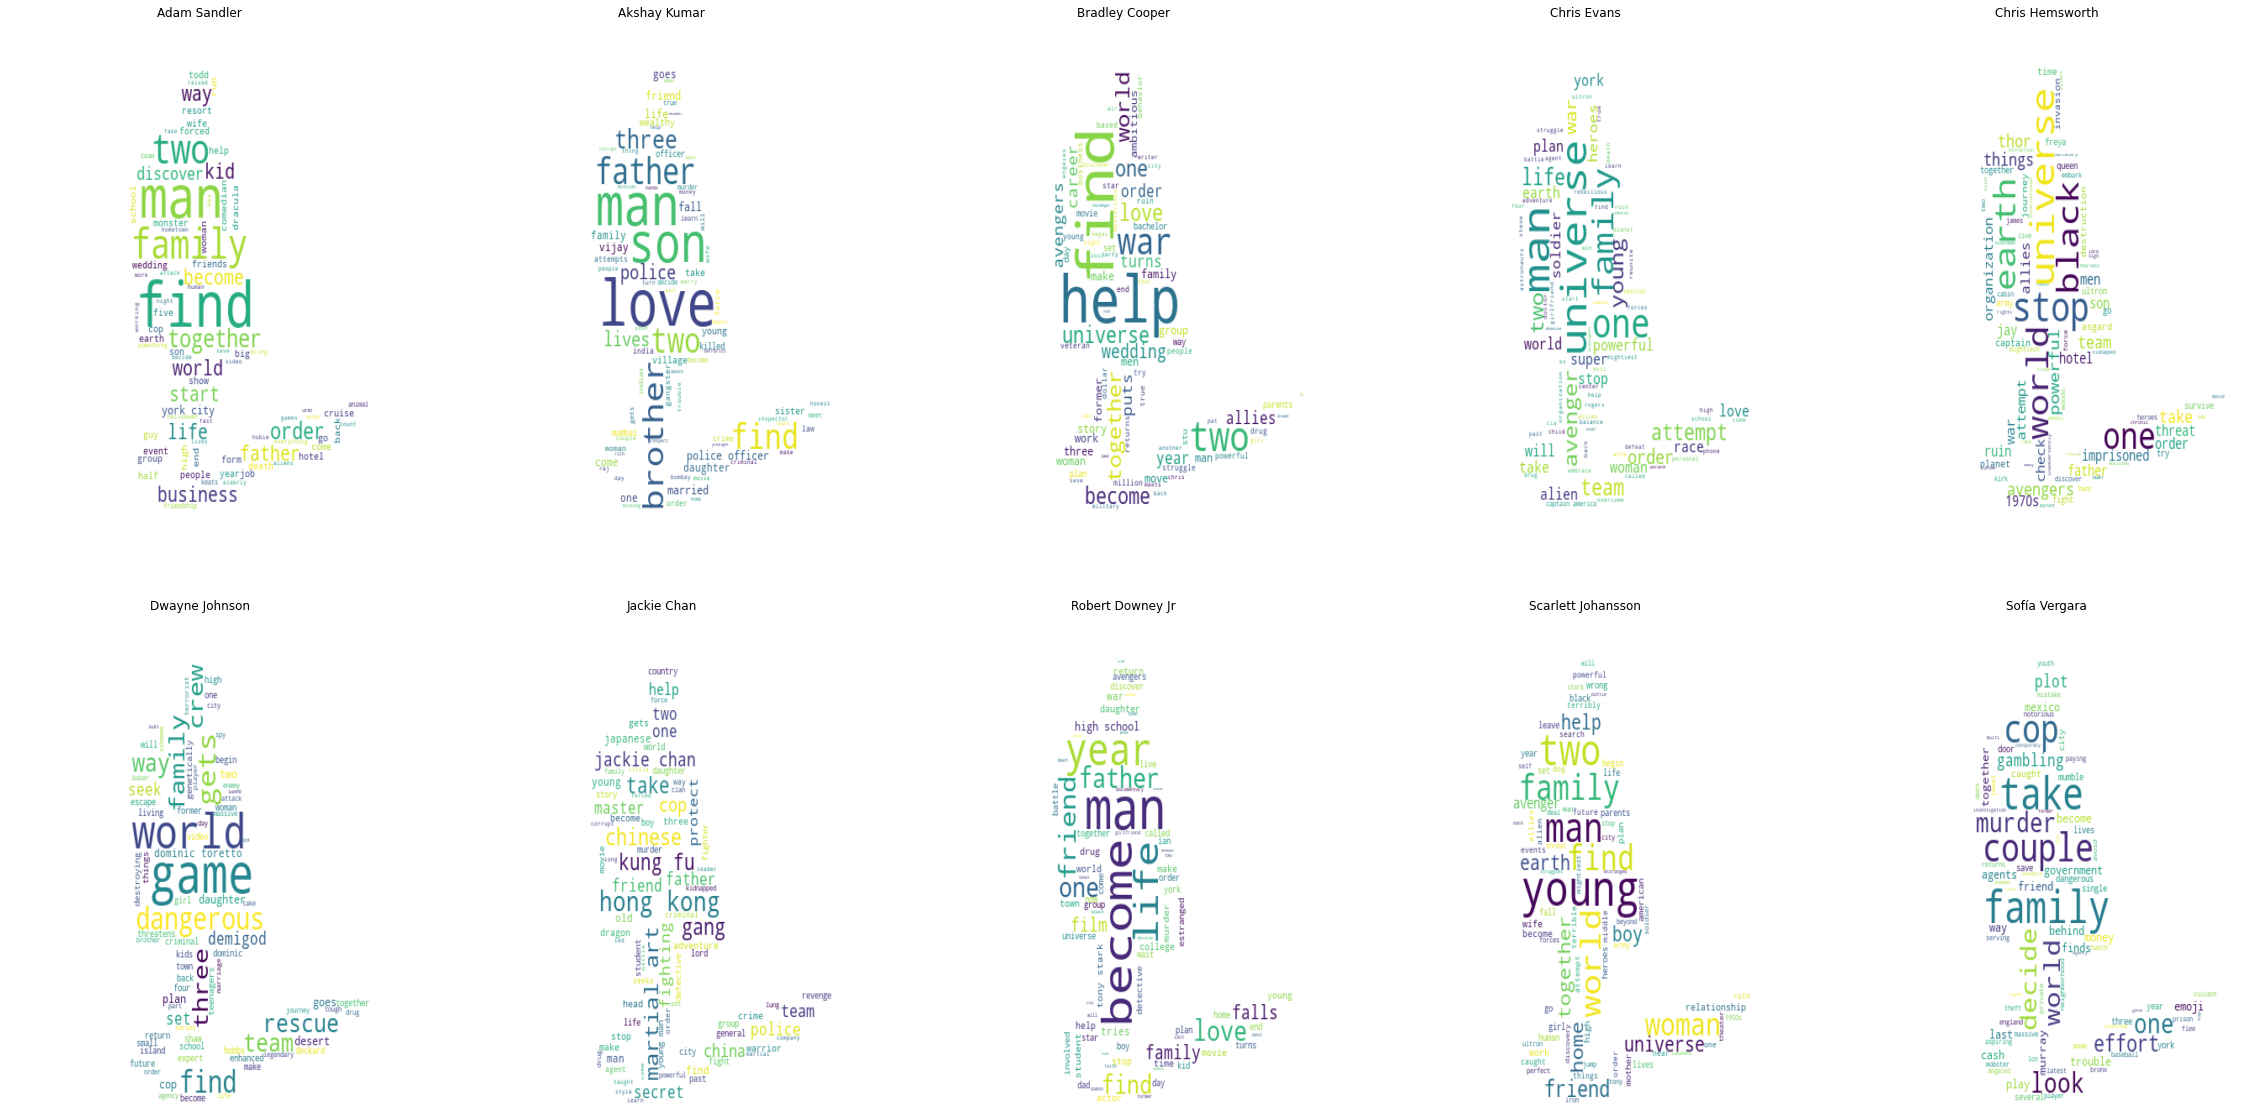

In [138]:
#os.chdir(os.getcwd() +'\\descriptions')
fig, axs = plt.subplots(2, 5)
fig.set_size_inches(40, 20)
row = 0
col = 0
for file in os.listdir():
    if file.endswith('.txt'):
        with open(file) as f:
            
            text = f.read()
            text.replace('see full summary »', '')
            stopwords = set(list(STOPWORDS)+['full summary', 'see', 'full', 'see full', 'summary', 'new', 'must'])
            mask = np.array(Image.open("mask.jpg"))
            wordcl = WordCloud(stopwords=stopwords, background_color="white", mask=mask, max_words=80).generate(text)

            
            axs[row, col].plot()
            axs[row, col].imshow(wordcl, interpolation='bilinear', aspect='auto')
            axs[row, col].axis('off')
            axs[row, col].set_title(file.split('.')[0])
            col += 1
            if col == 5:
                row = 1
                col = 0
            
            
            

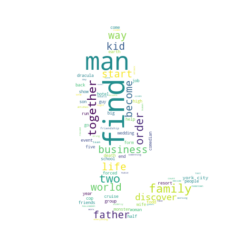

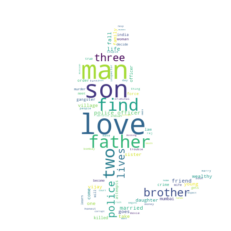

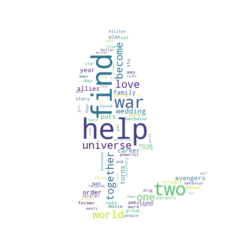

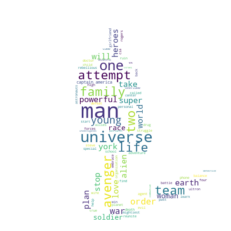

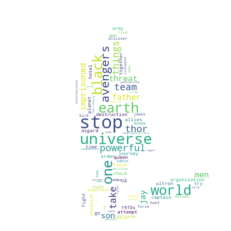

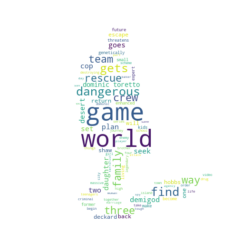

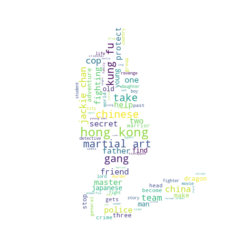

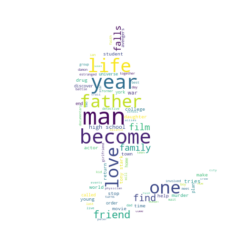

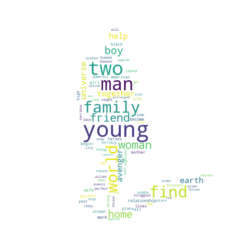

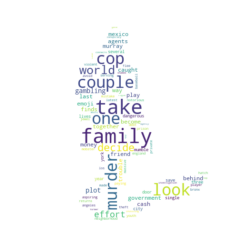

In [140]:
os.chdir('descriptions')
for file in os.listdir():
    if file.endswith('.txt'):
        with open(file) as f:
            
            text = f.read()
            text.replace('see full summary »', '')
            stopwords = set(list(STOPWORDS)+['full summary', 'see', 'full', 'see full', 'summary', 'new', 'must'])
            mask = np.array(Image.open("mask.jpg"))
            wordcl = WordCloud(stopwords=stopwords, background_color="white", mask=mask, max_words=80).generate(text)
            
            plt.plot()
            plt.imshow(wordcl, interpolation='bilinear', aspect='equal')
            plt.axis('off')
            plt.show()

In [244]:
os.chdir('..')

# NETWORKX GRAPHS

In [241]:
distance_matrix = np.load('distances.npy')

In [232]:
actors_to_find = [('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/'), ('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/'),
                 ('Robert Downey Jr.', 'https://www.imdb.com/name/nm0000375/'), ('Akshay Kumar', 'https://www.imdb.com/name/nm0474774/'),
                 ('Jakcie Chan', 'https://www.imdb.com/name/nm0000329/'), ('Bradley Cooper', 'https://www.imdb.com/name/nm0177896/'),
                 ('Adam Sandler','https://www.imdb.com/name/nm0001191/'), ('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/'),
                ('Sofia Vergara', 'https://www.imdb.com/name/nm0005527/'), ('Chris Evans', 'https://www.imdb.com/name/nm0262635/')]

In [216]:
def draw_graph(include=None):
    G = nx.Graph()
    for i in range(10):
        for j in range(9, i, -1):
            w = distance_matrix[i][j]
            if 0 < w < 4:
                if not include or (include and w == include):
                    G.add_edge(actors_to_find[i][0], actors_to_find[j][0], weight = w, r=int(w))
    
    len_1 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 1] 
    len_2 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2] 
    len_3 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 3]
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=300)

    nx.draw_networkx_edges(G, pos, edgelist=len_1, width=2, edge_color = 'red')
    nx.draw_networkx_edges(G, pos, edgelist=len_2, width=2, edge_color="orange")
    nx.draw_networkx_edges(G, pos, edgelist=len_3, width=2, edge_color="grey")
    # labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    edge_labels = nx.get_edge_attributes(G, 'r')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
    plt.figure(figsize=(2,2))
    plt.axis("off")
    plt.show()

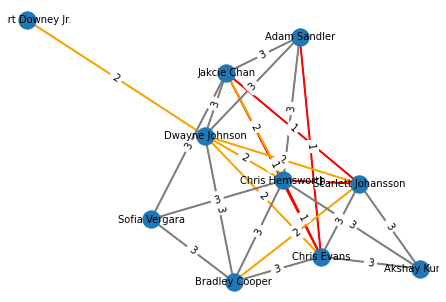

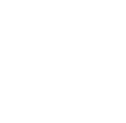

In [231]:
draw_graph()

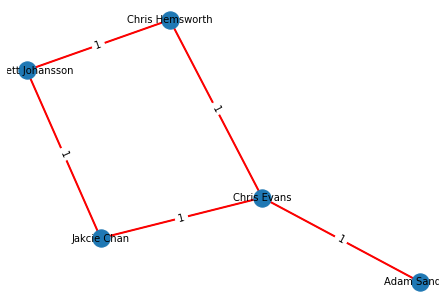

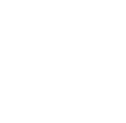

In [217]:
draw_graph(1)

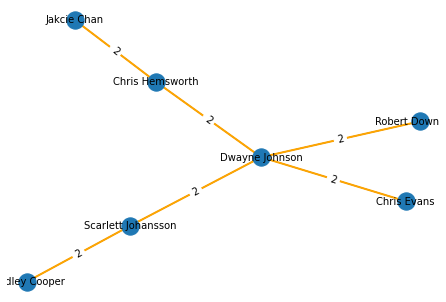

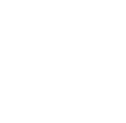

In [218]:
draw_graph(2)

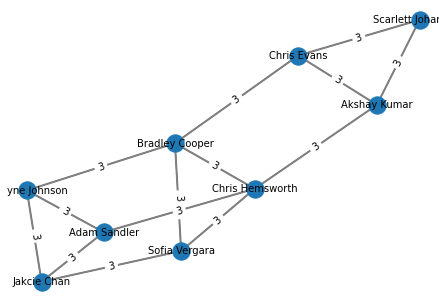

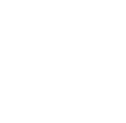

In [219]:
draw_graph(3)

# FIND PATH FROM DATABASE


In [ ]:
def find_func(start_url, sq_actor, sq_movie, sq_actor_visited, sq_movie_visited, finish_url, counter=0, cursor=cursor):
    if counter > 6:
        return "Probably no connection through movies here"
    while sq_actor:
        cur_act = sq_actor.popleft()
        sq_actor_visited.add(cur_act)
        cursor.execute("select mov_id from test_relations where act_id = %s;", (cur_act,))
        movs_res = cursor.fetchall()
        for mov in movs_res:
            if mov[0] not in sq_movie_visited:
                d.setdefault(mov[0], cur_act)
                sq_movie.append(mov[0])

    while sq_movie:
        cur_mov = sq_movie.popleft()
        sq_movie_visited.add(cur_mov)
        cursor.execute("select act_id from test_relations where mov_id = %s;", (cur_mov,))
        acts_res = cursor.fetchall()
        for act in acts_res:
            if act[0] == destination:
                path = [act[0], cur_mov]
                a = d[cur_mov]
                while True:
                    path.append(a)
                    x = d[a]
                    path.append(x)
                    a = d[x]
                    path.append(a)
                    if a == start:
                        return path
            if act[0] not in sq_actor_visited:
                d.setdefault(act[0], cur_mov)
                sq_actor.append(act[0])

    return find_func(start, sq_actor, sq_movie, sq_actor_visited, sq_movie_visited, finish_url, counter+=1)
    

In [ ]:
 def find_actors(start_url, finish_url):
    sq_actor = deque()
    sq_movie = deque()
    sq_actor_visited = set()
    sq_movie_visited = set()
    d = dict()
    params = config()
    sq_actor.append(start_url)
    connection = psycopg2.connect(**params)
    with connection.cursor() as cursor:
        return find_func(start_url, sq_actor, sq_movie, sq_actor_visited, sq_movie_visited, finish_url, cursor=cursor)

In [ ]:
find_actors("nm4609675", finish_url)

In [ ]:
tt12528166/

In [6]:
with open(r'C:\Users\glady\Downloads\In_use\Пихтон\Пихтон\Data_Scrapin\descriptions\descriptions\Adam Sandler.txt') as f:
    w = f.read()

In [7]:
#get all movie descriptions

def get_descriptions():
    params = config()
    connection = psycopg2.connect(**params)
    with connection.cursor() as cursor:
        psycopg2.extras.execute_batch(cursor, """
        SELECT mov_id from movies;""")
        movies = cursor.fetchall()
    connection.close()

"despite his devotion to his hometown of salem (and its halloween celebration), hubie dubois is a figure of mockery for kids and adults alike. but this year, something is going bump in the night, and it's up to hubie to save halloween. with his debts mounting and angry collectors closing in, a fast-talking new york city jeweler risks everything in hope of staying afloat and alive. a new york cop and his wife go on a european vacation to reinvigorate the spark in their marriage, but end up getting framed and on the run for the death of an elderly billionaire. count dracula and company participate in a cruise for sea-loving monsters, unaware that their boat is being commandeered by the monster-hating van helsing family. two fathers with opposing personalities come together to celebrate the wedding of their children. they are forced to spend the longest week of their lives together, and the big day cannot come soon enough. an estranged family gathers together in new york city for an event

In [2]:
import math

In [21]:
movies[:10]

['https://imdb.com/title/tt1032819',
 'https://imdb.com/title/tt0421869',
 'https://imdb.com/title/tt6723592',
 'https://imdb.com/title/tt0947810',
 'https://imdb.com/title/tt0091875',
 'https://imdb.com/title/tt0495026',
 'https://imdb.com/title/tt0117308',
 'https://imdb.com/title/tt0052950',
 'https://imdb.com/title/tt2120144',
 'https://imdb.com/title/tt4935926']

In [3]:
def get_descriptions(samp=100):
    params = config()
    connection = psycopg2.connect(**params)
    with connection.cursor() as cursor:
        cursor.execute("""
        SELECT mov_id from test_movies1;""")
        movies = cursor.fetchall()
        movies = ['https://imdb.com/title/' + x[0] for x in movies]

        descr_to_upload = []
        for batch in tqdm.tqdm(range(math.ceil(len(movies)/100))):
            current_links = movies[batch*samp:(batch+1)*samp]
            
            loop = asyncio.get_event_loop()
            nest_asyncio.apply()
            responses = asyncio.run(get_soups_acts(current_links, sem))
            inp = zip([BeautifulSoup(resp) for resp in responses], [x.split('/')[-1] for x in current_links])
            descr_to_upload.extend([get_movie_description(i) for i in inp])
            if len(descr_to_upload) > 30000:
                upload_description(descr_to_upload, connection)
                descr_to_upload.clear()
        upload_description(descr_to_upload, connection)
        connection.commit()

In [15]:
def get_movie_description(inp):
    movie_soup, mov_id = inp
    try:
        description = movie_soup.find('section', attrs={'data-testid': 'Storyline'}).find('div', attrs={'class': 'ipc-html-content'}).findChild()
        description = list(description.children)[0]

        #short_desc = movie_soup.find('p', attrs={'data-testid': 'plot'}).findChild('span').text
    except AttributeError as e:
        print(e)
        print('MOV_ID: ', mov_id)
        return ('\\N', mov_id)
    return description, mov_id
    

In [16]:
def upload_description(upload_data, connection):
    with connection.cursor() as cursor:
        psycopg2.extras.execute_batch(cursor, """
        UPDATE test_movies1 SET description = %s where mov_id = %s;""", upload_data)

In [17]:
get_descriptions()

100%|████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]

'NoneType' object has no attribute 'find'
MOV_ID:  (tt1032819,"\\N","\\N","\\N")


In [33]:
address = movies[0]
resp = requests.get(address)
soup = BeautifulSoup(resp.content)
get_movie_description(soup)

Los Angelenos meet on Christmas Eve through chance, tragedy, and divine intervention. Velvet Larry is the sleazy owner of the strip club where the glamorous but struggling single mother Rose Johnny dances. Qwerty Doolittle is a shy young mortician who falls in love with her. Randall is the head of a corporate crime organization who tries to convince a former employee just released from prison not to seek vengeance on his former co-workers. Charlie is a suicidally depressed ex-priest. Lexus is a lonely transsexual prostitute who shares an unexpected bond with the former priest.


In [37]:
a = np.array([(1,'a', 'b'), (1, 'g', 'c'), (1, 'h', 'z')])
a[:, 1:]

array([['a', 'b'],
       ['g', 'c'],
       ['h', 'z']], dtype='<U11')

In [58]:
connection.close()

In [18]:
movies = ['https://imdb.com/title/tt1032819',
 'https://imdb.com/title/tt0421869',
 'https://imdb.com/title/tt6723592',
 'https://imdb.com/title/tt0947810',
 'https://imdb.com/title/tt0091875',
 'https://imdb.com/title/tt0495026',
 'https://imdb.com/title/tt0117308',
 'https://imdb.com/title/tt0052950',
 'https://imdb.com/title/tt2120144',
 'https://imdb.com/title/tt4935926']

In [21]:
address = movies[1]
resp = requests.get(address)
soup = BeautifulSoup(resp.content)
get_movie_description((soup, 'tt1032819'))

('This story follows four friends transplanted from New York to Los Angeles to follow thier acting dreams. The four get distracted in four very different ways but all involve women. From obsession with the unreal to the older and wiser woman, to the how many beautiful ladies can their be in this town, and lets not forget the focus on will she ever come back to me syndrome. Trials and tribulations occur between their friendship and their relationships with very different women in this romantic comedy',
 'This story follows four friends transplanted from New York to Los Angeles to follow thier acting dreams. The four get distracted in four very different ways but all involve women. From obses... Read all',
 'tt1032819')